In [24]:
import pandas as pd
import random
from sklearn import preprocessing
import string
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

In [2]:
names_data = pd.read_csv("datasets/gender_by_names/names.csv")

names_data.head()

,Name,Gender
0,Aamir,Male
1,Aaron,Female
2,Aaron,Male
3,Abagael,Female
4,Abagail,Female


In [3]:
len(names_data)

10132

In [4]:
len(names_data['Name'].unique())

9543

In [5]:
names_data = names_data.drop_duplicates(subset=['Name'],
                                        keep=random.choice(['first', 'last']))

In [6]:
len(names_data)

9543

In [7]:
names_data.head()

,Name,Gender
0,Aamir,Male
2,Aaron,Male
3,Abagael,Female
4,Abagail,Female
5,Abbe,Female


In [8]:
le = preprocessing.LabelEncoder()
names_data['Gender'] = le.fit_transform(names_data['Gender'])
names_data.head()

,Name,Gender
0,Aamir,1
2,Aaron,1
3,Abagael,0
4,Abagail,0
5,Abbe,0


In [9]:
genders = ['Female', 'Male']

In [10]:
all_letters = string.ascii_letters + " .,;'"

In [11]:
n_letters = len(all_letters)
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [12]:
def name_to_tensor(name):
    name_in_tensor = torch.zeros(len(name), 1, n_letters)
    for i, letter in enumerate(name):
        name_in_tensor[i][0][all_letters.find(letter)] = 1

    return name_in_tensor

In [13]:
name_to_tensor('a')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [14]:
name_to_tensor('aA')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [15]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [16]:
n_hidden = 128
n_genders = len(genders)

rnn = RNN(n_letters, n_hidden, output_size=n_genders)

In [17]:
iterations = 100000
criterion = nn.NLLLoss()
learning_rate = 0.005

In [18]:
def output_to_gender(output):

    top_n, top_index = output.topk(1)
    pred_i = top_index[0].item()
    pred = genders[pred_i]

    return pred

In [19]:
for iteration in range(1, iterations + 1):

    i = random.randint(0, len(names_data) - 1)

    name = names_data.iloc[i][0]
    name_in_tensor = name_to_tensor(name)

    gender = names_data.iloc[i][1]
    gender_in_tensor = torch.LongTensor([gender])

    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(name_in_tensor.size()[0]):
        output, hidden = rnn(name_in_tensor[i], hidden)

    loss = criterion(output, gender_in_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    if iteration % 5000 == 0:

        pred = output_to_gender(output)

        correct = '✓' if pred == genders[gender] else '✗ (%s)' % genders[gender]
        print('iters- %d %d%% (%s) Name- %s Gender- %s %s' % \
              (iteration, iteration/iterations*100, loss.item(), name, pred, correct))

C:\Users\natha\AppData\Local\Temp\ipykernel_7536\1460729713.py:21: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1174.)
  p.data.add_(-learning_rate, p.grad.data)


iters- 5000 5% (2.451145887374878) Name- Bela Gender- Female ✗ (Male)
iters- 10000 10% (0.15420183539390564) Name- Rosalie Gender- Female ✓
iters- 15000 15% (0.1267431229352951) Name- Tucker Gender- Male ✓
iters- 20000 20% (0.5003519058227539) Name- Abdulkarim Gender- Male ✓
iters- 25000 25% (0.4103381037712097) Name- Angel Gender- Male ✓
iters- 30000 30% (0.15564747154712677) Name- Brandi Gender- Female ✓
iters- 35000 35% (0.004067007452249527) Name- Erinna Gender- Female ✓
iters- 40000 40% (0.2822185754776001) Name- Noach Gender- Male ✓
iters- 45000 45% (0.7760442495346069) Name- Pasquale Gender- Female ✗ (Male)
iters- 50000 50% (0.17016837000846863) Name- Nico Gender- Male ✓
iters- 55000 55% (0.02430010959506035) Name- Rana Gender- Female ✓
iters- 60000 60% (0.3996577262878418) Name- Audrie Gender- Female ✓
iters- 65000 65% (0.02462013065814972) Name- Cleva Gender- Female ✓
iters- 70000 70% (0.12492665648460388) Name- Syble Gender- Female ✓
iters- 75000 75% (0.0808592364192009) Name

In [20]:
n_confusion = 10000

prediction = []
actual = []

for _ in range(n_confusion):
    i = random.randint(0, len(names_data) - 1)
    name = names_data.iloc[i][0]
    name_in_tensor = name_to_tensor(name)

    gender_idx = names_data.iloc[i][1]
    gender_in_tensor = torch.LongTensor([gender_idx])

    hidden = rnn.initHidden()

    for j in range(name_in_tensor.size()[0]):
        output, hidden = rnn(name_in_tensor[j], hidden)

    pred = output_to_gender(output)

    prediction.append(pred)
    actual.append(genders[gender_idx])

In [21]:
np_prediction = np.array(prediction)
np_actual = np.array(actual)

In [22]:
cm = confusion_matrix(np.where(np_prediction == "Female", True, False),
                      np.where(np_actual == "Female", True, False))

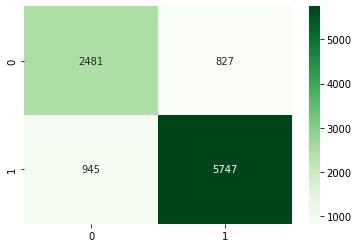

In [31]:
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens")